In [58]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs, nsdiffs


import json

In [30]:
# f = open()
data_df = pd.read_json('src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json')


In [31]:
data_df


,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2,timestamp
0,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544,2023-10-19 07:13:00
1,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000,2023-10-19 07:14:00
2,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000,2023-10-19 07:15:00
3,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778,2023-10-19 07:16:00
4,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333,2023-10-19 07:17:00
...,...,...,...,...,...,...,...,...,...
18282,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:55:00
18283,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:56:00
18284,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667,2023-10-31 23:57:00
18285,20.788429,938.428571,11.592286,1.985714,0.575893,31.372857,18.543286,473.928571,2023-10-31 23:58:00


In [32]:
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['timestamp'], unit="ms")) #.sort_index(ascending=True, inplace=False)
data_df = data_df.drop(columns=["timestamp"])



In [33]:
# pos = data_df.index[-1]
# data_df.loc[pos]
PERIODS1 = 12
data_df[data_df.index[-PERIODS1]:]["oxygen"]

timestamp
2023-10-31 23:48:00    20.782750
2023-10-31 23:49:00    20.782143
2023-10-31 23:50:00    20.786889
2023-10-31 23:51:00    20.786889
2023-10-31 23:52:00    20.788000
2023-10-31 23:53:00    20.788818
2023-10-31 23:54:00    20.788818
2023-10-31 23:55:00    20.787600
2023-10-31 23:56:00    20.787600
2023-10-31 23:57:00    20.787000
2023-10-31 23:58:00    20.788429
2023-10-31 23:59:00    20.788429
Name: oxygen, dtype: float64

In [34]:
train_data_size = int(data_df.shape[0] * 0.6)
df_train = data_df.iloc[:train_data_size]
df_test = data_df.iloc[train_data_size:]

In [9]:
df_test

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [11]:
def scale(df):
  scaler = StandardScaler()
  scaler.fit(df)

        # Scale data using the previously defined scaler
  df = pd.DataFrame(scaler.transform(df.copy()), 
                      columns=df.columns, 
                      index=df.index)
  
  return df, scaler


def unscale(df, scaler):
  df = pd.DataFrame(scaler.inverse_transform(df), 
                  columns=df.columns, 
                  index=df.index)
  
  return df

In [60]:
PERIODS = 12

def test_stationarity_kpss_adf(self, data, periods_in_season=None):
    if periods_in_season:
        # Estimate the number of differences using an ADF test:
        kpss_n_diffs = nsdiffs(np.array(data).astype(float), test='kpss', max_d=2)  # -> 0
        print(f"Stationarity: KPSS Test result: should be seasonally differenced {kpss_n_diffs}")

        adf_n_diffs = nsdiffs(np.array(data).astype(float), test='adf', max_d=2)  # -> 0
        print(f"Stationarity: ADF Test result: should be seasonally differenced {adf_n_diffs}")
    else:
        # Estimate the number of differences using an ADF test:
        kpss_n_diffs = ndiffs(np.array(data).astype(float), test='kpss', max_d=2)  # -> 0
        print(f"Stationarity: KPSS Test result: should be differenced {kpss_n_diffs}")

        adf_n_diffs = ndiffs(np.array(data).astype(float), test='adf', max_d=2)  # -> 0
        print(f"Stationarity: ADF Test result: should be differenced {adf_n_diffs}")

    return {
        "kpss": { "isStationary": kpss_n_diffs == 0, "ndiffs": kpss_n_diffs },\
        "adf" : { "isStationary": adf_n_diffs == 0, "ndiffs": adf_n_diffs },
    }

def convert_data_to_stationary(df):
  df_diff = df.copy()
  first_elements = {}
  seasonal_first_elements = {}

  def get_all_needed_diffs(df):
    selected_ndiffs_dict = {}
    for i in range(len(df.columns)):
        selected_ndiffs = np.max([stationarity_test_result["kpss"]["ndiffs"], stationarity_test_result["adf"]["ndiffs"]])
        selected_ndiffs_dict[df.columns[i]] = 2#selected_ndiffs

    return selected_ndiffs_dict
      
  selected_ndiffs = get_all_needed_diffs(df_diff)

  for key, value in selected_ndiffs.items():
    existing_array = seasonal_first_elements.get(key, [])
    # for i in range(value):
    pos = df_diff.index[-PERIODS]
    seasonal_first_elements[key] = existing_array + [df_diff[pos:][key]]
    df_diff[key] = df_diff[key].diff(PERIODS)
  # for key, value in selected_ndiffs.items():
  #     print(f"ndiffs {key} - {value}")
  #     for i in range(value):
  #       existing_array = first_elements.get(key, [])
  #       pos = df_diff[key].index[-1]
  #       print(f"POSITION > {pos}")          
  #       first_elements[key] = existing_array + [df_diff.loc[[pos],key]]
  #       df_diff[key] = df_diff[key].diff()

  max_diff = max(selected_ndiffs.values())
  print(f"before {df_diff}")
  df_diff = df_diff[PERIODS:]
  print(f"after {df_diff}")

  return df_diff, selected_ndiffs, seasonal_first_elements



In [41]:
data_df

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-19 07:13:00,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544
2023-10-19 07:14:00,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000
2023-10-19 07:15:00,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000
2023-10-19 07:16:00,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778
2023-10-19 07:17:00,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [15]:
data_df.iloc[0]

oxygen          20.764444
health         737.111111
dewpt           10.087778
TypPS            1.722222
gauss            0.375576
sound           74.277780
temperature     17.724889
co2            623.055544
Name: 2023-10-19 07:13:00, dtype: float64

In [54]:
def inverse_diff(s, last_observation):
    series_undifferenced = s.copy()
    series_undifferenced1 = pd.concat([last_observation, series_undifferenced], axis=0)
    # print(f"LAST OBS -> {series_undifferenced1}")
    for i in range(len(series_undifferenced)):
        # if i > 12:
        print(f"i: {i} {series_undifferenced.iloc[i]} {series_undifferenced1.iloc[i]} {series_undifferenced.iloc[i]+series_undifferenced1.iloc[i]}")
        pos = series_undifferenced.index[i]
        series_undifferenced1[pos] = series_undifferenced.iloc[i]+series_undifferenced1.iloc[i]
    # print(f"Series undiff {series_undifferenced.iloc[30]} {s.iloc[30]}")
    return series_undifferenced1

def df_inv_transformation(pred, diff_order, first_elements):
    df_transformed = pred.copy()  
    for key, value in diff_order.items():
        # print(f"KEY {key} - VAL {value}")
        # for i in range(value):
        # print(f"AAAAA first el: {first_elements}"
        print(first_elements[key][-1])
        df_transformed[key] = inverse_diff(df_transformed[key], first_elements[key][-1])

    return df_transformed

In [39]:
df_train.tail()

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:00:00,20.785400,950.500000,12.642800,2.010000,0.671963,31.3030,19.008800,712.890000
2023-10-26 22:01:00,20.785400,950.500000,12.642800,2.010000,0.671963,31.3030,19.008800,712.890000
2023-10-26 22:02:00,20.785000,975.000000,12.644000,1.300000,0.004300,31.2900,19.010000,712.700000
2023-10-26 22:03:00,20.781333,923.333333,12.641333,2.433333,0.580234,31.4500,19.007333,708.600000
2023-10-26 22:04:00,20.786250,962.750000,12.644250,1.475000,0.460647,31.2975,19.009750,709.999987


In [44]:
df_train_transformed, diff_order, first_elements = convert_data_to_stationary(df_train)
# df_train_transformed, df_train_transformed_scaler = scale(df_train_transformed)

df_testtt = pd.concat([df_train.tail(PERIODS), df_test], axis=0) # tail equals hardcoded selected diff
df_test_transformed, d, s = convert_data_to_stationary(df_testtt)
# df_test_transformed, df_test_transformed_scaler = scale(df_test_transformed)
df_test_transformed

before                        oxygen     health     dewpt     TypPS     gauss  \
timestamp                                                                
2023-10-19 07:13:00       NaN        NaN       NaN       NaN       NaN   
2023-10-19 07:14:00       NaN        NaN       NaN       NaN       NaN   
2023-10-19 07:15:00       NaN        NaN       NaN       NaN       NaN   
2023-10-19 07:16:00       NaN        NaN       NaN       NaN       NaN   
2023-10-19 07:17:00       NaN        NaN       NaN       NaN       NaN   
...                       ...        ...       ...       ...       ...   
2023-10-26 22:00:00 -0.002236  -0.500000 -0.012018  0.400909  0.253493   
2023-10-26 22:01:00 -0.002933  27.833333  0.000133 -0.023333  0.274783   
2023-10-26 22:02:00 -0.003333  52.333333  0.001333 -0.733333 -0.392880   
2023-10-26 22:03:00 -0.004917 -42.041667 -0.006542  1.070833  0.064822   
2023-10-26 22:04:00  0.007500  15.875000  0.001000 -0.287500 -0.199342   

                        sound 

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,0.002250,-1.375000,-0.001250,0.462500,-0.109934,-0.012500,0.000625,-2.062475
2023-10-26 22:06:00,0.000000,-35.833333,-0.001667,0.958333,0.417749,-0.130833,0.000833,-2.208333
2023-10-26 22:07:00,-0.007333,113.000000,-0.004667,-0.066667,-0.214366,0.010000,-0.003000,-2.133367
2023-10-26 22:08:00,-0.012100,20.045455,-0.002782,0.103636,-0.030051,0.045273,-0.001382,-2.840000
2023-10-26 22:09:00,-0.013400,40.745455,-0.001782,-0.656364,-0.184586,0.021273,-0.000782,-2.240000
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,0.002743,-0.171429,-0.015714,0.248571,0.073372,0.174000,0.000457,0.691429
2023-10-31 23:56:00,0.003600,-30.850000,-0.014500,0.745000,0.012697,0.249000,0.002600,0.770000
2023-10-31 23:57:00,0.002727,24.939394,-0.014182,-0.165152,-0.046186,0.088485,0.012348,1.925758


In [55]:
# df_test_transformed = unscale(df_test_transformed, df_test_transformed_scaler)
df_forecast_original = df_inv_transformation(df_test_transformed, diff_order, first_elements)


timestamp
2023-10-26 21:53:00    20.778750
2023-10-26 21:54:00    20.781000
2023-10-26 21:55:00    20.788000
2023-10-26 21:56:00    20.788100
2023-10-26 21:57:00    20.789400
2023-10-26 21:58:00    20.789400
2023-10-26 21:59:00    20.785500
2023-10-26 22:00:00    20.785400
2023-10-26 22:01:00    20.785400
2023-10-26 22:02:00    20.785000
2023-10-26 22:03:00    20.781333
2023-10-26 22:04:00    20.786250
Name: oxygen, dtype: float64
i: 0 0.0022500000000000853 20.77875 20.781
i: 1 0.0 20.781 20.781
i: 2 -0.007333333300000078 20.788 20.7806666667
i: 3 -0.012100000000000222 20.7881 20.776
i: 4 -0.013400000000000745 20.7894 20.776
i: 5 -0.00560000000000116 20.7894 20.7838
i: 6 -0.0016999999999995907 20.7855 20.7838
i: 7 -0.0008999999999979025 20.7854 20.7845
i: 8 -0.0055111110999988 20.7854 20.7798888889
i: 9 -0.005111111099999732 20.785 20.7798888889
i: 10 -0.0033333333000022947 20.7813333333 20.778
i: 11 -0.0032499999999977547 20.78625 20.783
i: 12 0.0003636363999994785 20.781 20.781363636

In [56]:
df_forecast_original.head(30)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.011000,711.683333
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.015222,709.977767


In [78]:
df_test.head(20)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.011000,711.683333
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.015222,709.977767


<Axes: xlabel='timestamp'>

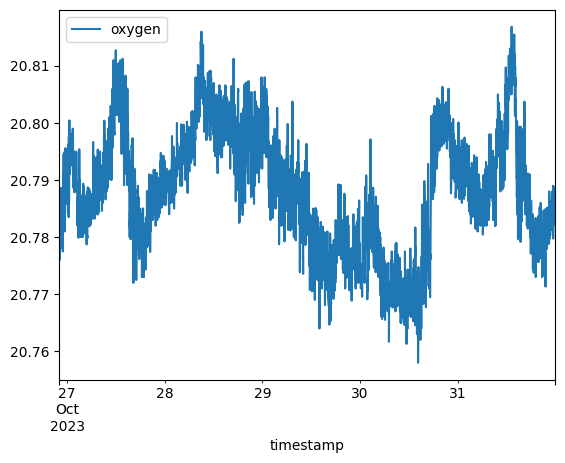

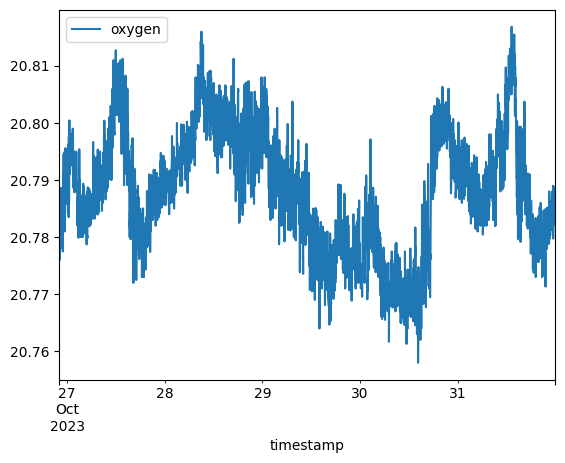

In [57]:
df_forecast_original.plot( y='oxygen')
df_test.plot( y='oxygen')

<Axes: xlabel='timestamp'>

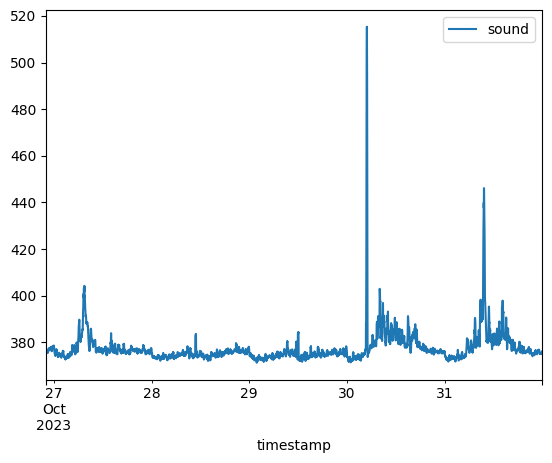

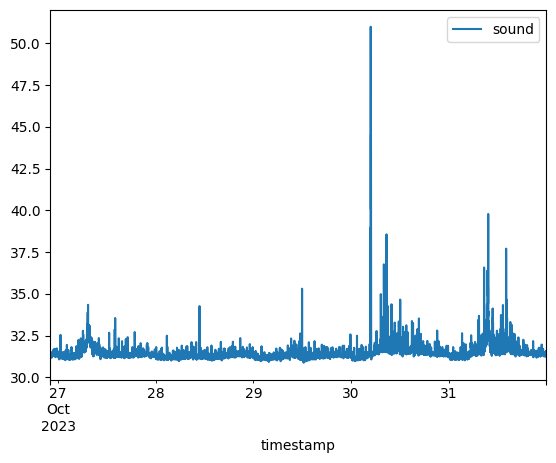

In [33]:
df_forecast_original.plot( y='sound')
df_test.plot( y='sound')

<Axes: xlabel='timestamp'>

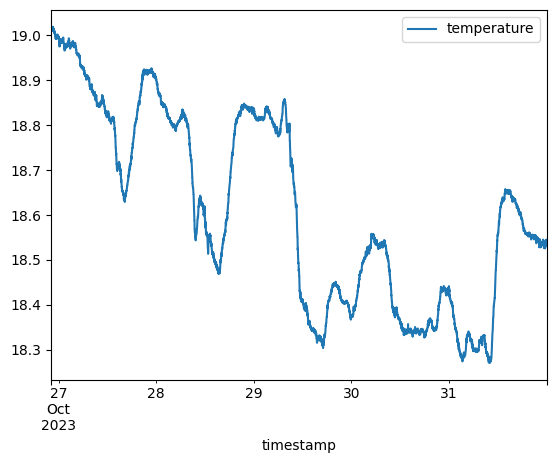

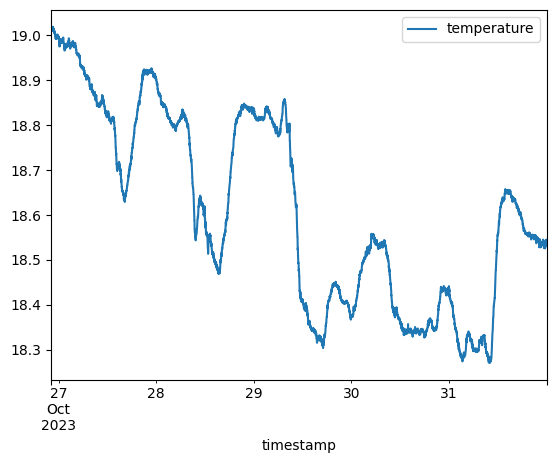

In [53]:
df_forecast_original.plot( y='temperature')
df_test.plot( y='temperature')

In [60]:
my_range[~my_range.isin(data_df.index)]

DatetimeIndex(['2023-10-19 07:13:24', '2023-10-19 07:13:28',
               '2023-10-19 07:13:32', '2023-10-19 07:13:40',
               '2023-10-19 07:13:44', '2023-10-19 07:13:52',
               '2023-10-19 07:13:56', '2023-10-19 07:14:04',
               '2023-10-19 07:14:08', '2023-10-19 07:14:12',
               ...
               '2023-10-31 23:59:00', '2023-10-31 23:59:04',
               '2023-10-31 23:59:08', '2023-10-31 23:59:12',
               '2023-10-31 23:59:20', '2023-10-31 23:59:24',
               '2023-10-31 23:59:28', '2023-10-31 23:59:32',
               '2023-10-31 23:59:36', '2023-10-31 23:59:40'],
              dtype='datetime64[ns]', length=254600, freq=None)

In [39]:
data_df.size

705609

In [66]:
data_df.duplicated().value_counts()
data_df = data_df.drop_duplicates()



In [67]:
data_df.size

705609

In [68]:
data_df_1m = data_df.groupby(pd.Grouper(key='timestamp', freq='1min')).mean()

In [69]:
data_df_1m

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-19 07:13:00,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544
2023-10-19 07:14:00,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000
2023-10-19 07:15:00,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000
2023-10-19 07:16:00,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778
2023-10-19 07:17:00,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [72]:
df_filled = data_df_1m.bfill()

In [73]:
df_filled

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-19 07:13:00,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544
2023-10-19 07:14:00,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000
2023-10-19 07:15:00,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000
2023-10-19 07:16:00,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778
2023-10-19 07:17:00,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [75]:
my_range_in1m = pd.date_range(start=df_filled.index.min(), end=df_filled.index.max(), freq='1min')


In [77]:
len(my_range_in1m[~my_range_in1m.isin(df_filled.index)])


0

In [79]:
df_filled["timestamp"] = df_filled.index

In [80]:
df_filled.to_json('./src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json', orient="records")

In [12]:
grouped = data_df.groupby('Entity')

In [13]:
data_df['Entity'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia', 'Asia excl. China',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor',
       'Ecuador', 'Egypt', 'El Salvador', 'Equator

In [14]:
data_df = data_df[data_df["Entity"] == 'Austria']

In [15]:
data_df

,Entity,Code,Day,Weekly cases
24930,Austria,AUT,2020-01-10,0
24931,Austria,AUT,2020-01-11,0
24932,Austria,AUT,2020-01-12,0
24933,Austria,AUT,2020-01-13,0
24934,Austria,AUT,2020-01-14,0
...,...,...,...,...
26587,Austria,AUT,2024-07-24,12
26588,Austria,AUT,2024-07-25,12
26589,Austria,AUT,2024-07-26,12
26590,Austria,AUT,2024-07-27,12


In [16]:
data_df.isna().sum()

Entity          0
Code            0
Day             0
Weekly cases    0
dtype: int64

In [17]:
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df["Day"])) #.sort_index(ascending=True, inplace=False)


In [18]:
data_df

,Entity,Code,Day,Weekly cases
Day,,,,
2020-01-10,Austria,AUT,2020-01-10,0
2020-01-11,Austria,AUT,2020-01-11,0
2020-01-12,Austria,AUT,2020-01-12,0
2020-01-13,Austria,AUT,2020-01-13,0
2020-01-14,Austria,AUT,2020-01-14,0
...,...,...,...,...
2024-07-24,Austria,AUT,2024-07-24,12
2024-07-25,Austria,AUT,2024-07-25,12
2024-07-26,Austria,AUT,2024-07-26,12


In [16]:
my_range = pd.date_range(start=data_df['Day'].min(), end=data_df['Day'].max(), freq='D')


In [17]:
len(my_range[~my_range.isin(data_df.index)])


0

In [18]:
my_range.drop_duplicates()

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06',
               '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10',
               '2024-05-11', '2024-05-12'],
              dtype='datetime64[ns]', length=1534, freq='D')

In [19]:
print(data_df.shape)
new_df = pd.DataFrame()
new_df.index = my_range
new_df["Day"] = my_range
data_df = pd.merge(data_df, new_df, how="outer", right_index=True, left_index=True, validate="many_to_many")

(1534, 5)


In [20]:
data_df.index.drop_duplicates()
print(data_df)


             Entity Code       Day_x  Total confirmed deaths due to COVID-19  \
2020-03-01  Austria  AUT  2020-03-01                                     NaN   
2020-03-02  Austria  AUT  2020-03-02                                     NaN   
2020-03-03  Austria  AUT  2020-03-03                                     NaN   
2020-03-04  Austria  AUT  2020-03-04                                     NaN   
2020-03-05  Austria  AUT  2020-03-05                                     NaN   
...             ...  ...         ...                                     ...   
2024-05-08  Austria  AUT  2024-05-08                                 22534.0   
2024-05-09  Austria  AUT  2024-05-09                                 22534.0   
2024-05-10  Austria  AUT  2024-05-10                                 22534.0   
2024-05-11  Austria  AUT  2024-05-11                                 22534.0   
2024-05-12  Austria  AUT  2024-05-12                                 22534.0   

            Total confirmed cases of CO

In [21]:
data_df = data_df.groupby(data_df.index).last()

In [22]:
data_df = data_df.drop_duplicates(keep='last')

In [23]:
print(f"Duplicates: {data_df.index.duplicated()}")


Duplicates: [False False False ... False False False]


In [24]:
data_df = data_df.drop(columns=['Day_x', 'Day_y'])


In [25]:
data_df["Day"] = data_df.index

In [26]:
data_df.isna().sum()

Entity                                     0
Code                                       0
Total confirmed deaths due to COVID-19    14
Total confirmed cases of COVID-19          0
Day                                        0
dtype: int64

In [27]:
data_df = data_df.fillna(0)

In [19]:
data_df

,Entity,Code,Day,Weekly cases
Day,,,,
2020-01-10,Austria,AUT,2020-01-10,0
2020-01-11,Austria,AUT,2020-01-11,0
2020-01-12,Austria,AUT,2020-01-12,0
2020-01-13,Austria,AUT,2020-01-13,0
2020-01-14,Austria,AUT,2020-01-14,0
...,...,...,...,...
2024-07-24,Austria,AUT,2024-07-24,12
2024-07-25,Austria,AUT,2024-07-25,12
2024-07-26,Austria,AUT,2024-07-26,12


In [20]:
data_df1 = pd.read_csv('src/api/data/weekly-covid-deaths.csv')

In [21]:
grouped = data_df1.groupby('Entity')


In [22]:
data_df1 = data_df1[data_df1["Entity"] == 'Austria']

In [23]:
data_df1.isna().sum()

Entity           0
Code             0
Day              0
Weekly deaths    0
dtype: int64

In [24]:
data_df1.index = pd.DatetimeIndex(pd.to_datetime(data_df1["Day"])) #.sort_index(ascending=True, inplace=False)


In [32]:
data_df = data_df.drop(columns=['Entity', 'Code'])
data_df

,Weekly cases
Day,
2020-01-10,0
2020-01-11,0
2020-01-12,0
2020-01-13,0
2020-01-14,0
...,...
2024-07-24,12
2024-07-25,12
2024-07-26,12


In [33]:
data_df1 = data_df1.drop(columns=['Entity', 'Code'])
data_df1

,Weekly deaths
Day,
2020-01-10,0
2020-01-11,0
2020-01-12,0
2020-01-13,0
2020-01-14,0
...,...
2024-07-24,0
2024-07-25,0
2024-07-26,0


In [34]:
joint = data_df.join(data_df1, how='inner', on="Day")

In [36]:
joint

,Weekly cases,Weekly deaths
Day,,
2020-01-10,0,0
2020-01-11,0,0
2020-01-12,0,0
2020-01-13,0,0
2020-01-14,0,0
...,...,...
2024-07-24,12,0
2024-07-25,12,0
2024-07-26,12,0


In [38]:
joint["timestamp"] = joint.index

In [39]:
joint.to_json('./src/api/data/non-cumulative-deaths-and-cases-covid_14-08-24_Austria.json', orient="records")